# Problem Set #5

### MACS 30150, Dr. Evans
### Ruixi Li

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt

## 1. Some income data, lognormal distribution, and GMM

In [2]:
# Load the data as a NumPy array
pts = np.loadtxt("data/incomes.txt")

#### (a)

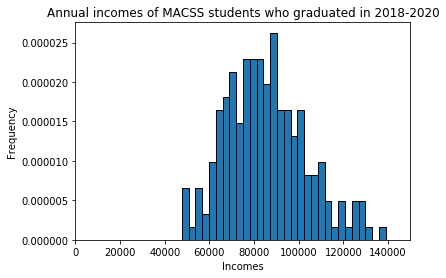

In [3]:
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020') 
plt.xlabel('Incomes')
plt.ylabel('Frequency')
plt.xlim([0, 150000])
plt.show()

#### (b)

In [4]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu)) - \
                      sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))

    pdf_vals = ((1/(x*sigma * np.sqrt(2 * np.pi)) 
                 * np.exp( -(np.log(x)-mu)**2 / (2*sigma**2))) 
                / prob_notcut)

    return pdf_vals

In [5]:
# define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix
def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.std()
    return mean_data, var_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x*trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2)*trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    return mean_model, np.sqrt(var_model)

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params,  * args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple = False)
    crit_val = err.T @ W @ err
    return crit_val

In [6]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args = (gmm_args), tol = 1e-14,
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1 = ', mu_GMM1, ' sig_GMM1 = ', sig_GMM1)
results

mu_GMM1 =  11.333599613401043  sig_GMM1 =  0.21325529509280705


      fun: array([[6.39928436e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14975054e-08, -2.93650036e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

In [7]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points  = ', mean_data, ', Standard Deviation of points  = ', var_data)
print('Mean of model  = ', mean_model, ', Standard Deviation  = ', var_model)
print('Error vector = ', err1)
results

Mean of points  =  85276.82360625811 , Standard Deviation of points  =  17992.542128046523
Mean of model  =  85276.82405854674 , Standard Deviation  =  17992.54168300891
Error vector =  [ 5.30376967e-09 -2.47345601e-08]


      fun: array([[6.39928436e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14975054e-08, -2.93650036e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


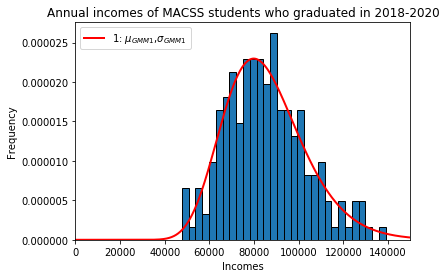

In [8]:
# Plot the histogram of the data
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020') 
plt.xlabel('Incomes')
plt.ylabel('Frequency')
plt.xlim([0, 150000])

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth = 2, color = 'r', label = '1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc = 'upper left')
plt.show()

#### (c)

In [9]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple = False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts)  **  2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts)  **  2) - var_model) / var_model
    
    return Err_mat

In [10]:
Err_mat  = get_Err_mat2(pts, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[4.45167060e-02 1.68385288e+03]
 [1.68385288e+03 9.54184437e+08]]
[[ 2.40701668e+01 -4.24767141e-05]
 [-4.24767141e-05  1.12297423e-09]]


In [11]:
gmm_args = (pts, 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
results2 = opt.minimize(criterion, params_init, args = (gmm_args), tol = 1e-14,
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2 = ', mu_GMM2, ' sig_GMM2 = ', sig_GMM2)

mean_model2, var_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points  = ', mean_data, ', Standard Deviation of points  = ', var_data)
print('Mean of model  = ', mean_model2, ', Standard Deviation of model  = ', var_model2)
print('Error vector = ', err2)
print('GMM criterion function:',results2.fun)

mu_GMM2 =  11.333599603618692  sig_GMM2 =  0.2132552944762103
Mean of points  =  85276.82360625811 , Standard Deviation of points  =  17992.542128046523
Mean of model  =  85276.82324643606 , Standard Deviation of model  =  17992.541506074205
Error vector =  [-4.21945887e-09 -3.45683402e-08]
GMM criterion function: [[4.28528844e-16]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


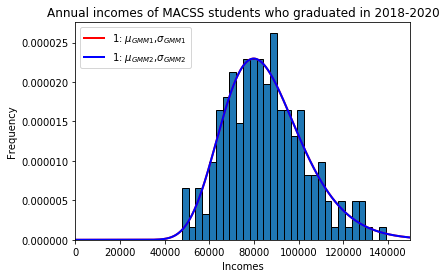

In [12]:
# Plot the histogram of the data
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020') 
plt.xlabel('Incomes')
plt.ylabel('Frequency')
plt.xlim([0, 150000])

# Plot the estimated GMM1 PDF1
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth = 2, color = 'r', label = '1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc = 'upper left')

# Plot the estimated GMM2 PDF3
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth = 2, color = 'b', label = '1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc = 'upper left')
plt.show()

#### (d)

In [13]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals <75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >=  100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion3(params,  * args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple = False)
    crit_val = err.T @ W @ err 
    return crit_val

In [14]:
W_hat1_3 = np.eye(3)
gmm_args = (pts, 0.0, 150000.0, W_hat1_3)

results_3 = opt.minimize(criterion3, params_init, args = (gmm_args),
                       method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3 = ', mu_GMM1_3, ' sig_GMM1_3 = ', sig_GMM1_3)
err3 = err_vec3(pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)

bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
pert1, pert2, pert3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)

print('Error vector = ', err3)
print('GMM criterion function:',results_3.fun)
bpct = [bpct_1_dat, bpct_2_dat, bpct_3_dat],
pert = [pert1, pert2, pert3],
print('percent', ['Percent <75000','Percent 75000~100000','Percent > = 100000'])
print('Data Moments', bpct)
print('Model Moments', pert)

mu_GMM1_3 =  11.33670517992345  sig_GMM1_3 =  0.2115135161076993
Error vector =  [ 1.13768208e-08  1.18261327e-08 -4.66305616e-08]
GMM criterion function: [[2.44369875e-15]]
percent ['Percent <75000', 'Percent 75000~100000', 'Percent > = 100000']
Data Moments ([0.3, 0.5, 0.2],)
Model Moments ([0.3000000034130462, 0.5000000059130664, 0.19999999067388768],)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


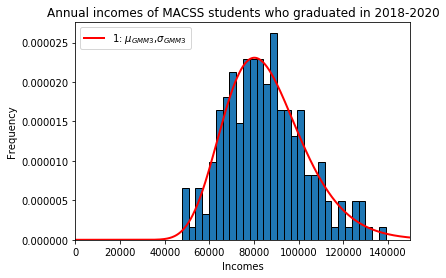

In [15]:
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020') 
plt.xlabel('Incomes')
plt.ylabel('Frequency')
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth = 2, color = 'r', label = '1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc = 'upper left')

plt.show()

#### (e)

In [16]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple = False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >=  75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >=  100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >=  75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >=  100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [17]:
Err_mat3w = get_Err_mat3(pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3w = (1 / pts.shape[0]) * (Err_mat3w @ Err_mat3w.T)
print(VCV2_3w)
W_hat2_3 = lin.pinv(VCV2_3w)
print(W_hat2_3)

[[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
[[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [18]:
gmm_args = (pts, 0.0, 150000.0, W_hat2_3)
results_4 = opt.minimize(criterion3, params_init, args = (gmm_args),method = 'L-BFGS-B')
mu_GMM1_3w, sig_GMM1_3w = results_4.x
print('mu_GMM1_3w = ', mu_GMM1_3w, ' sig_GMM1_3w = ', sig_GMM1_3w)
err3w = err_vec3(pts, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0)

print('Error vector = ', err3w)
print('GMM criterion function:',results_4.fun)
bpct = [bpct_1_dat, bpct_2_dat, bpct_3_dat],
pert = [pert1, pert2, pert3],
print('percent', ['Percent <75000','Percent 75000~100000','Percent > = 100000'])
print('Data Moments', bpct)
print('Model Moments', pert)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if sys.path[0] == '':


mu_GMM1_3w =  11.333599613401043  sig_GMM1_3w =  0.21325529509280705
Error vector =  [ 0.02208416 -0.00875996 -0.01122634]
GMM criterion function: [[0.00020989]]
percent ['Percent <75000', 'Percent 75000~100000', 'Percent > = 100000']
Data Moments ([0.3, 0.5, 0.2],)
Model Moments ([0.306625249295193, 0.49562001855191595, 0.1977547321528913],)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


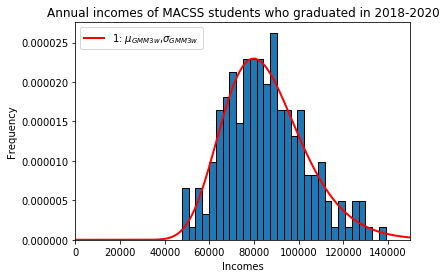

In [19]:
num_bins = 30
plt.hist(pts, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020') 
plt.xlabel('Incomes')
plt.ylabel('Frequency')
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000),
         linewidth = 2, color = 'r', label = '1: $\mu_{GMM3w}$,$\sigma_{GMM3w}$')
plt.legend(loc = 'upper left')
plt.show()

#### (f)

In [20]:
mu = [mu_GMM1, mu_GMM2, mu_GMM1_3, mu_GMM1_3w]
sig = [sig_GMM1, sig_GMM2, sig_GMM1_3, sig_GMM1_3w]
GMMV = [results.fun, results2.fun, results_3.fun, results_4.fun]
print('mu=', mu)
print('sig=', sig)
print('GMMV=', GMMV)

mu= [11.333599613401043, 11.333599603618692, 11.33670517992345, 11.333599613401043]
sig= [0.21325529509280705, 0.2132552944762103, 0.2115135161076993, 0.21325529509280705]
GMMV= [array([[6.39928436e-16]]), array([[4.28528844e-16]]), array([[2.44369875e-15]]), array([[0.00020989]])]


The model from (c) fit the model best, because it has the lowest minimized GMM function value. 

## 2. Linear regression and GMM

#### (a)

In [21]:
df = pd.read_csv("data/sick.txt").astype('float64')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [22]:
def err_vec(df, b0, b1, b2, b3):
    yhat = b0 + b1 * df['age'] + b2 * df['children'] + b3 * df['avgtemp_winter']
    y = df['sick']
    err_vec = yhat - y
    return err_vec

def crit(params,  * args):
    b0, b1, b2, b3 = params
    df, W = args
    err = err_vec(df, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

In [23]:
b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(df.shape[0])
gmm_args = (df, W_hat)
results = opt.minimize(crit, params_init, args = (gmm_args), tol = 1e-14,method = 'L-BFGS-B')
b0, b1, b2, b3 = results.x
print("b0=", b0)
print("b1=", b1)
print("b2=", b2)
print("b3=", b3)
print('GMM criterion function:', results.fun)
results

b0= 0.2516448637202974
b1= 0.012933469665776062
b2= 0.4005009851118556
b3= -0.009991708484318558
GMM criterion function: 0.0018212898056107383


      fun: 0.0018212898056107383
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.24997925e-07, -7.38688624e-07, -8.87371773e-06,  9.37791511e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 235
      nit: 14
   status: 0
  success: True
        x: array([ 0.25164486,  0.01293347,  0.40050099, -0.00999171])